# CS145: Project 3 | Project Name

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* Joey Guman, joeytg
* Allison Guman, aguman

## Project Overview

---
The primary question we are trying to answer is the relationship between various indicators of a country's development and economics and how that country contributes to the emission of CO2 emissions. The role of CO2 emissions and other greenhouse gasses has become a central debate over how countries of the world should handle the threat of human induced climate change. Many organizations like the World Bank and the United Nations consider correcting climate change to be a central issue to be solved amongst other indicators of sustainability and development like equality in wealth and representation. 

As such, we try to connect various indicators of development to CO2 emissions. We believe that if we can find how features like education, wealth, and culture relate the emissions, we can figure out how to best curb CO2 emissions with informed policy.

We will focus on the trends by country in recent years to maximize relevance. Specifically, we will be focusing on data collected by the World Bank across years 2005 and 2018. We will be predicting an individual country's CO2 emissions per capita based of it this data. 

To answer this question, we will also try to explore the relationship between gender equality and general quality of education.
We will also explore the question of how a country being developed versus actively developing affects their volume of emissions.

---


## Analysis of Dataset

---

We will be pulling from 3 datasets.

The World Bank datasets are structured slightly differently from most datasets shown in class. Each row accounts for one metric of a single country's development from literacy of the adult population to rates of vaccinations in newborns. So rather than a model where each row corresponds to a country and stores values for the various indicators, each country has several rows in the table each for an individual indicator in a particular year, marked by an indentifying indicator code. As such, in order to receive multiple features about a country, many way merges will be required. We focus on two datasets described below that together make up 1.39 GB. They can be linked accross by country_name and country_code, though have their own indicators and indicator values to contribute to our analysis

world_bank_wdi



  /indicators_data (798.45MB): The most comprehensive dataset in our project. This table is responsible for the majority of indicators of general development by country and year. This dataset is useful for its valuable indicators of education, wealth, and particularly per capita emissions of CO2


----

In [ ]:
%%bigquery --project $project_id
SELECT country_name, indicator_code, indicator_name, value, year
FROM `bigquery-public-data.world_bank_wdi.indicators_data`
ORDER BY year DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,country_name,indicator_code,indicator_name,value,year
0,Myanmar,SP.POP.7579.MA.5Y,"Population ages 75-79, male (% of male populat...",7.956159e-01,2020
1,Mozambique,PA.NUS.PPPC.RF,Price level ratio of PPP conversion factor (GD...,3.457243e-01,2020
2,Myanmar,DT.TDS.DECT.GN.ZS,Total debt service (% of GNI),7.564206e-01,2020
3,Myanmar,DT.NFL.PRVT.CD,"PPG, private creditors (NFL, current US$)",-2.569900e+07,2020
4,Mozambique,SE.PRM.PRIV.ZS,"School enrollment, primary, private (% of tota...",1.969780e+00,2020
5,Mozambique,SP.POP.2024.MA.5Y,"Population ages 20-24, male (% of male populat...",9.476697e+00,2020
6,Myanmar,NE.CON.TOTL.ZS,Final consumption expenditure (% of GDP),6.821561e+01,2020
7,Myanmar,IQ.SCI.MTHD,Methodology assessment of statistical capacity...,7.000000e+01,2020
8,Myanmar,FD.RES.LIQU.AS.ZS,Bank liquid reserves to bank assets ratio (%),1.676446e+01,2020
9,Mozambique,SE.PRM.ENRR.MA,"School enrollment, primary, male (% gross)",1.218967e+02,2020


/world_bank_intl_education (595.93MB): This dataset is formatted identically to indicators_data but it has several more in depth indicators focused on education. In this project we use this table to make predictions between general quality of education in a country to its gender representations.

census_bureau_international 

This table schema works more closely to what we have seen in class where each row represents a (country, year) pair and individual features are stored column wise. Individual tables store different values for our countries, such as population data. Together, these datasets account for 708.68 kB.

  /country_names_area (5.18KB): This table stores the names of countries and their land area. A lot of the data in the World Bank datasets is assigned to regional groups of countries such as 'World' and 'South Asia.' In our analysis, we want to analyze and predict using data points only for individual countries, and we use this dataset to extract exactly these countries from our datasets from the World Bank. We necessarily take this approach as running predictions on only regions would involve bleeding data between training, validation, and testing sets where certain regional sets contain data from individual countries processed separately. We also use this table information to run qualitative measurements about a country's land area as an intrinsic property held by countries and not something that can be changed.

  /midyear_population (703.5 kB): This table stores populations of a country by year with predictions for future years as well. This table is important to us as we are able to use it to engineer features surrounding density.

  Between tables, we use country name and year to indentify individual data points of interest for our analysis and prediction.

In [ ]:
%%bigquery --project $project_id
SELECT  country_name, country_area
FROM `bigquery-public-data.census_bureau_international.country_names_area`
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,country_name,country_area
0,Afghanistan,652230.0
1,Albania,27398.0
2,Algeria,2381741.0
3,American Samoa,198.0
4,Andorra,468.0
5,Angola,1246700.0
6,Anguilla,91.0
7,Antigua and Barbuda,442.6
8,Argentina,2736690.0
9,Armenia,28203.0


In [ ]:
%%bigquery --project $project_id
SELECT country_name, midyear_population, year
FROM `bigquery-public-data.census_bureau_international.midyear_population`
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,country_name,midyear_population,year
0,Aruba,49712,1950
1,Aruba,51335,1951
2,Aruba,51955,1952
3,Aruba,52585,1953
4,Aruba,53220,1954
5,Aruba,53865,1955
6,Aruba,54516,1956
7,Aruba,55176,1957
8,Aruba,55843,1958
9,Aruba,56518,1959


## Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "basicproject-364421"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

We begin our analysis with the relationship between country size and greenhouse gas emissions so as to help get an idea of natural variations between countries' emissions values in relation to intrinsic qualities of size (measured by  population and land mass). We start with this because land area is a good heurisic measurement of the availability of a counry to carry out operations and leverage resources that contribute to greenhouse gas emissions. For instance a larger country may be more likely to have access to fossil fuel stores that allow the entire country to easily access polluting fuel. Similarly perhaps a larger or a smaller country's population makes it more likely to be wealthy, which is generally understood to be related to greenhouse gas emissions or contribute to greater demands within the country for goods and services such as car transport for many people that inflates emissions. Comparing the strength of correlations between these two factors to CO2 per capita gas emissions will reveal insights about the nature of the problem.

In [75]:
%%bigquery population_to_pollution --project $project_id
SELECT country.midyear_population as independent, x.value as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.census_bureau_international.midyear_population` country
WHERE x.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.country_name = country.country_name
AND x.year = country.year

Query is running:   0%|          |

Downloading:   0%|          |

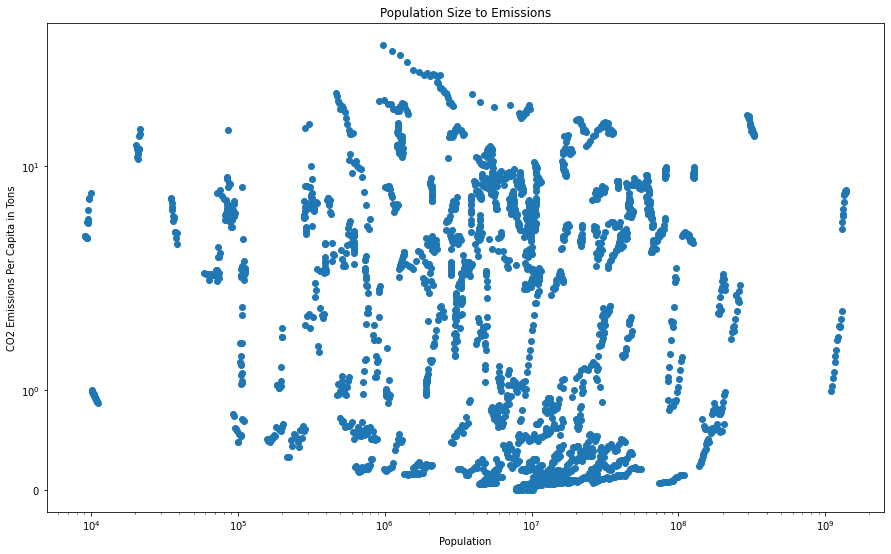

In [76]:
temp = population_to_pollution.copy()
plt.figure(figsize=(15,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Population Size to Emissions")
plt.xlabel("Population")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.yscale("symlog")
plt.xscale("log")

In [77]:
%%bigquery landarea_to_pollution --project $project_id
SELECT country.country_area as independent, x.value as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.census_bureau_international.country_names_area` country
WHERE x.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.country_name = country.country_name

Query is running:   0%|          |

Downloading:   0%|          |

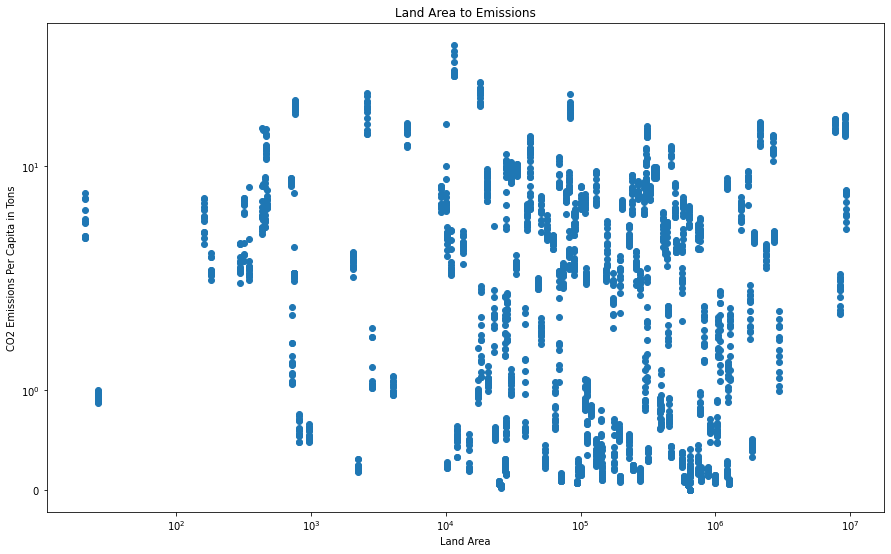

In [78]:
temp = landarea_to_pollution.copy()
plt.figure(figsize=(15,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Land Area to Emissions")
plt.xlabel("Land Area")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.yscale("symlog")
plt.xscale("symlog")

This was interesting as originally we hypothesized that similarly sized countries may have general tendencies that would encourage the average person to live differently or the average company to operate differently, however we see no clear correlation. This may be because countries of similar sizes may have vastly different factors with far more impact on emissions, which we will explore in the following analysis. Our next theory is a rough estimation that countries with high population density correlate with high emissions as a heuristic for development. We will try this using an engineered feature found by dividing a country's population by its land area.

In [79]:
%%bigquery density_to_pollution --project $project_id
SELECT population.midyear_population / country.country_area as independent, x.value as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.census_bureau_international.country_names_area` country,
`bigquery-public-data.census_bureau_international.midyear_population` population
WHERE x.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = population.year
AND x.country_name = country.country_name
AND x.country_name = population.country_name

Query is running:   0%|          |

Downloading:   0%|          |

2380


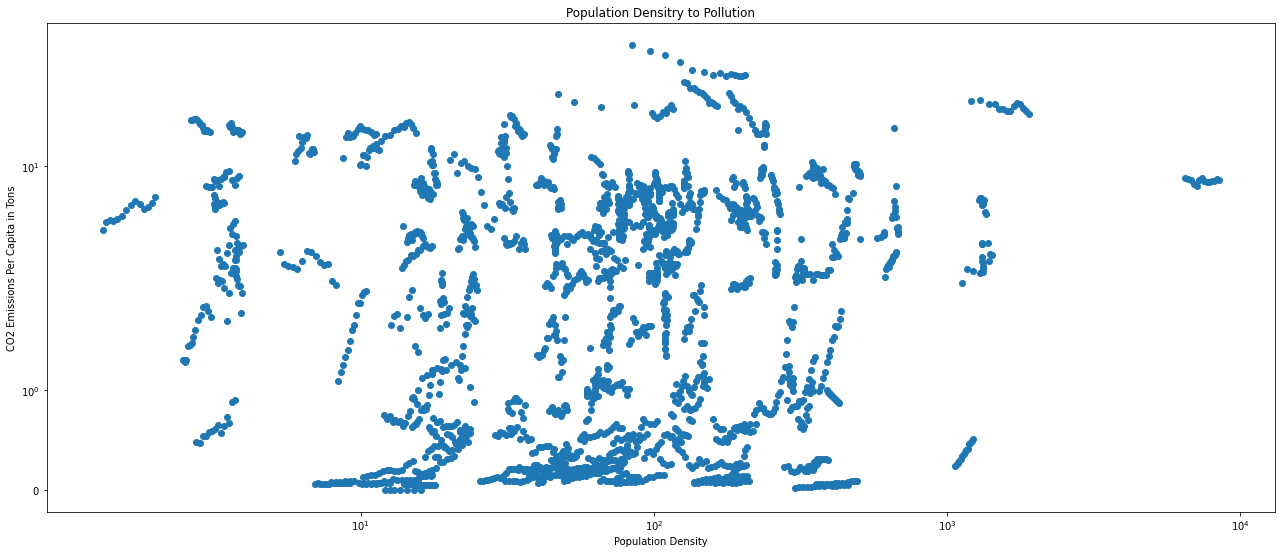

In [80]:
temp = density_to_pollution.copy()
print(len(temp["dependent"]))
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Population Densitry to Pollution")
plt.xlabel("Population Density")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.yscale("symlog")
plt.xscale("symlog")

Surprisingly we see population density works as a poor metric to capture levels of urbanization, which would contribute to higher emissions. We can try directly running the percentage of the population living in urban environments with more than a million people to see if this is a more reliable metric for urbanization and development that contributes to CO2 emissions. Luckily this is a precalculated metric by the World Bank.

In [81]:
%%bigquery urban_dwelling_to_pollutions --project $project_id
SELECT x.value as independent, y.value as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y,
`bigquery-public-data.census_bureau_international.midyear_population` country
WHERE x.indicator_code = 'EN.URB.MCTY.TL.ZS'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.country_name = country.country_name
AND x.country_code = y.country_code
AND x.year = country.year

Query is running:   0%|          |

Downloading:   0%|          |

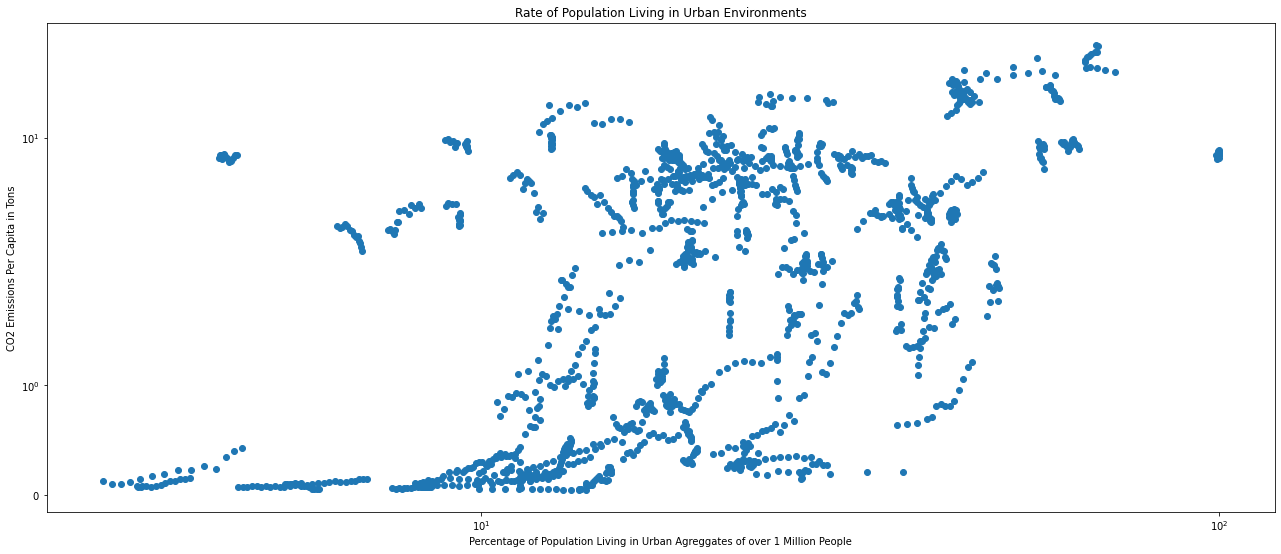

In [86]:
temp = urban_dwelling_to_pollutions.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Rate of Population Living in Urban Environments")
plt.xlabel("Percentage of Population Living in Urban Agreggates of over 1 Million People")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.xscale("symlog")
plt.yscale("symlog")

Here we see a much more clear correlation existing within the data. A common explanation for CO2 emmission is in population density, but here we see that a more reliable metric is the scale on considerably sized population centers rather than a uniform density.

Our next theory is on comparing economic inequality with CO2 emissions. We are curious to see what relationship emerges becase of two contradicting reasons. Institutions like the United Nations and the World Bank consider sustainable development amongst its goals with other general quality of life standards like economic equality. As such perhaps we may find that success in economic equality may be correlated to success in other metrics. However, it is also widely understood that developed countries have much higher rates of CO2 emissions, and developed countries generally possess higher rates of economic equality.
As an initial estimate let's try to compare the amount of wealth held by the bottom 20 percent of the population.

In [83]:
%%bigquery poverty_to_pollution --project $project_id
SELECT AVG(x.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y,
`bigquery-public-data.census_bureau_international.midyear_population` country
WHERE x.indicator_code = 'SI.DST.FRST.20'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.country_name = country.country_name
AND x.country_code = y.country_code
AND x.year = country.year
GROUP BY x.country_name

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'CO2 Emissions Per Capita in Tons')

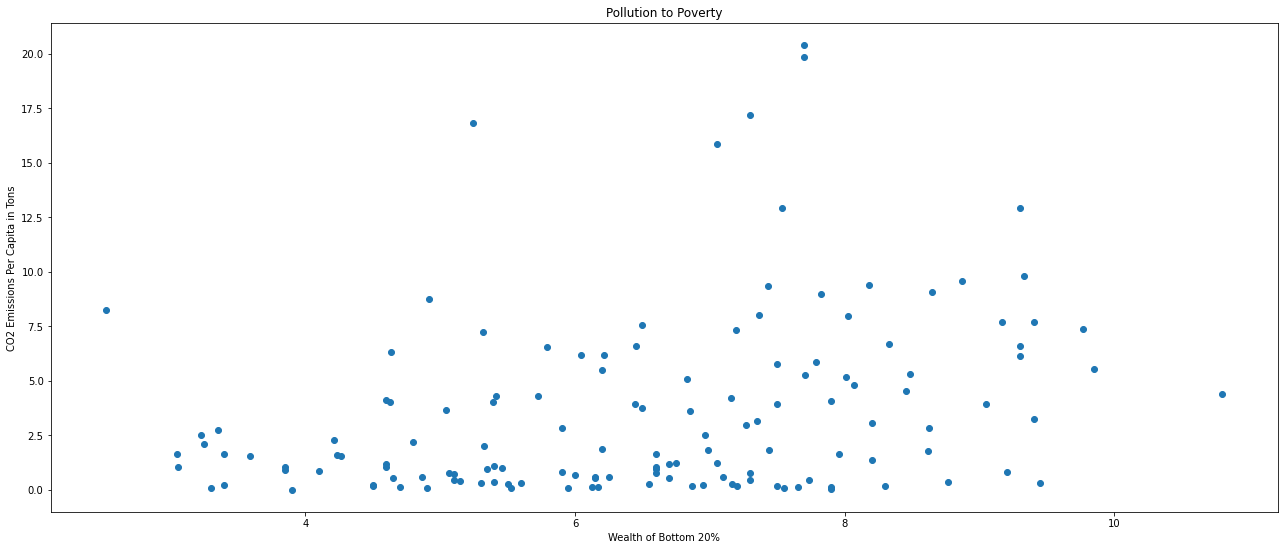

In [85]:
temp = poverty_to_pollution.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Pollution to Poverty")
plt.xlabel("Wealth of Bottom 20%")
plt.ylabel("CO2 Emissions Per Capita in Tons")

Though, we observe a postive correlation, we decided to consider an additional engineered feature that attempts to more directly measure economic inequality to validate our findings.
We propose taking a ratio of the percentage of wealth heald by the top 10 percent over the bottom 10 percent, as generally wealth inequalities are considered more characterized by the upper echelon possessing extreme wealth.

In [87]:
%%bigquery inequality_to_pollution --project $project_id
SELECT AVG(xlow.value / xhigh.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` xlow,
`bigquery-public-data.world_bank_wdi.indicators_data` xhigh, `bigquery-public-data.world_bank_wdi.indicators_data` y,
`bigquery-public-data.census_bureau_international.country_names_area` country
WHERE xlow.indicator_code = 'SI.DST.FRST.10'
AND xhigh.indicator_code = 'SI.DST.10TH.10'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND xlow.year >= 2005
AND xlow.year <= 2018
AND xlow.year = y.year
AND xlow.year = xhigh.year
AND xlow.country_name = country.country_name
AND xlow.country_name = xhigh.country_name
AND xlow.country_code = y.country_code
GROUP BY xlow.country_name

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'CO2 Emissions Per Capita in Tons')

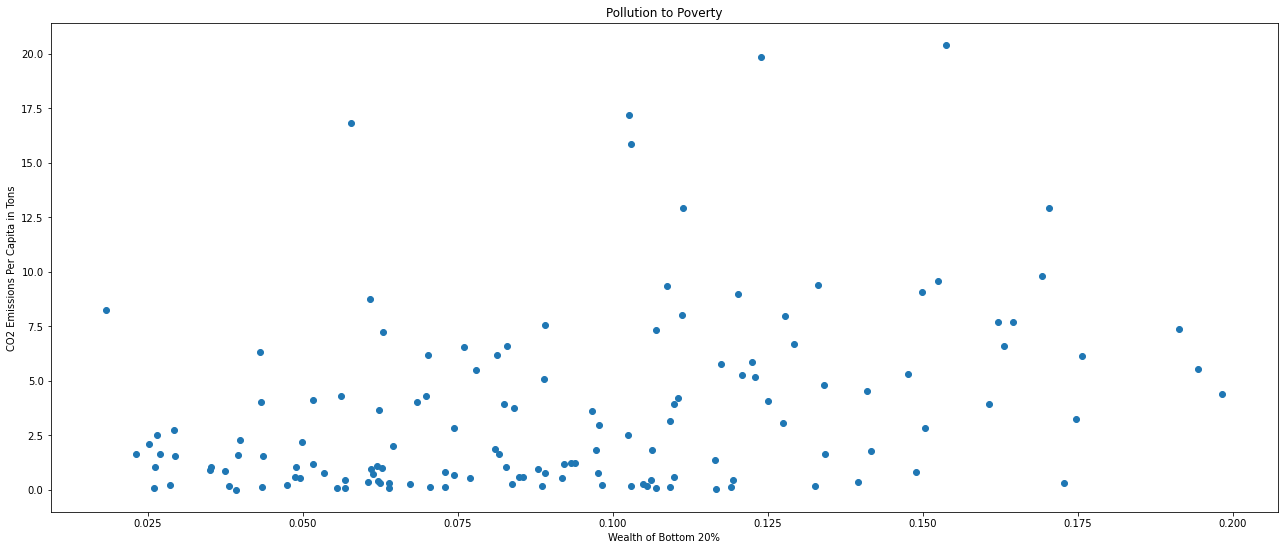

In [89]:
temp = inequality_to_pollution.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Pollution to Poverty")
plt.xlabel("Wealth of Bottom 20%")
plt.ylabel("CO2 Emissions Per Capita in Tons")

We see a very similar distribution as before, further validating our earlier observation.

In [90]:
%%bigquery data6 --project $project_id
SELECT AVG(x.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y,
`bigquery-public-data.census_bureau_international.midyear_population` country
WHERE x.indicator_code = 'EG.ELC.ACCS.ZS'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.country_name = country.country_name
AND x.country_code = y.country_code
AND x.year = country.year
GROUP BY x.country_code

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'CO2 Emissions Per Capita in Tons')

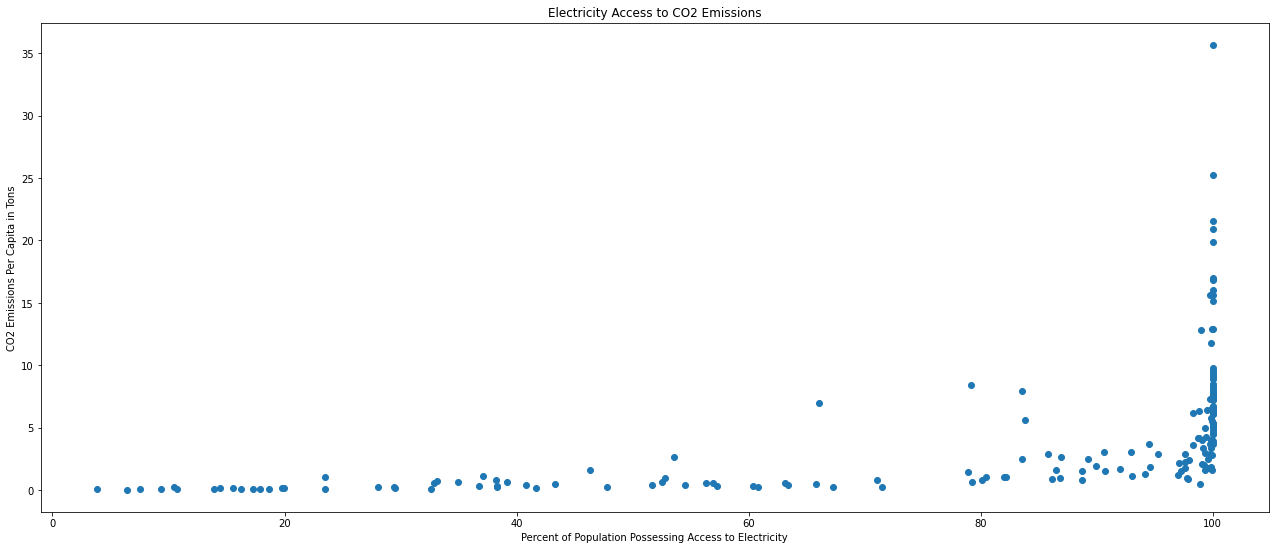

In [91]:
temp = data6.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Electricity Access to CO2 Emissions")
plt.xlabel("Percent of Population Possessing Access to Electricity")
plt.ylabel("CO2 Emissions Per Capita in Tons")

In [46]:
%%bigquery discretizing_engineered_feature --project $project_id
SELECT aggregated.disc as disc, AVG(aggregated.emissions) as averages
FROM (SELECT IF(AVG(x.value) < 95, 'Low Electricity Acess', 'High Electricity Acess') as disc, AVG(y.value) as emissions 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y,
`bigquery-public-data.census_bureau_international.midyear_population` country
WHERE x.indicator_code = 'EG.ELC.ACCS.ZS'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.country_name = country.country_name
AND x.country_code = y.country_code
AND x.year = country.year
GROUP BY x.country_code) as aggregated
GROUP BY aggregated.disc

Query is running:   0%|          |

Downloading:   0%|          |

Interestingly, we find that unlike previous correlations there is not a continuous relationship between countries possessing different values. However in this scenario we find a near binary separation between countries above and below a 95 percent access to electricity. At first, we theorized that higher emissions per capita may be a gradual process as a country begins to industrialize prior to the complete implementation of access to electricity, but it seems as though the near uniformation distribution of electricity is a general prerequisite for a country to begin releasing significant CO2 emissions. This information helps to reinforce the World-systems theory, which proposes that different countries in the world have taken on categorical roles as core countries, semi-periphery countries, and periphery countries. We will engineer this feature as a binary variable so as to make our linearly weighted model better able to process the data.

Text(0, 0.5, 'CO2 Emissions Per Capita in Tons')

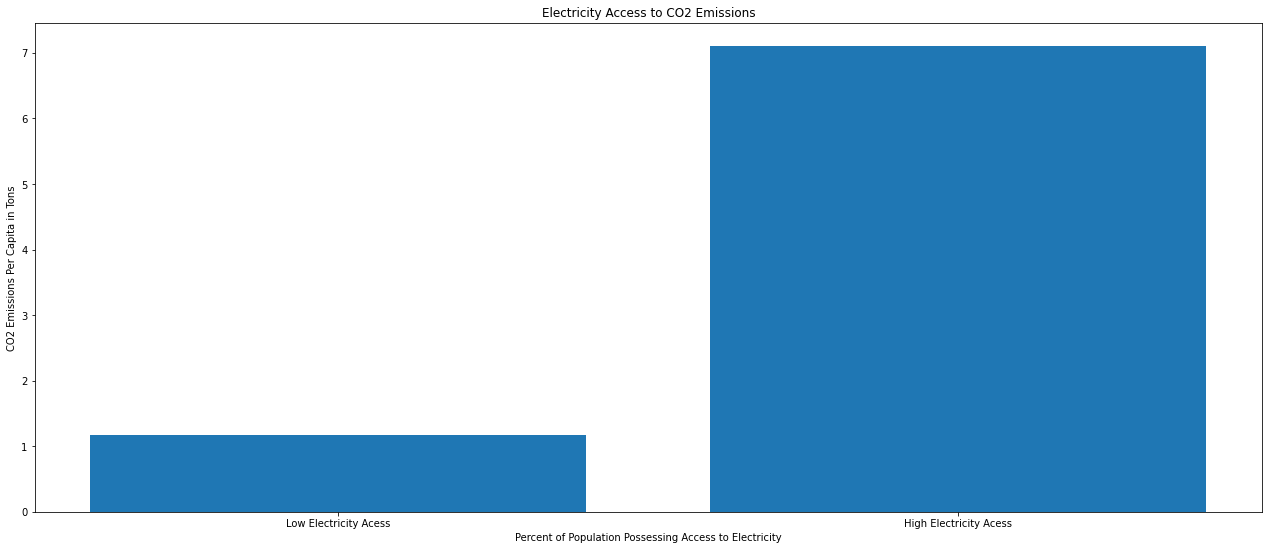

In [52]:
temp = discretizing_engineered_feature.copy()
plt.figure(figsize=(22,9))
plt.bar(temp["disc"], temp["averages"])
plt.title("Electricity Access to CO2 Emissions")
plt.xlabel("Percent of Population Possessing Access to Electricity")
plt.ylabel("CO2 Emissions Per Capita in Tons")

Our next observation is on the relationship between tourism as an industry. The independent variable is percent of total exports made up by international tourism, which serves as a metric for the economic stake of a country in tourism. 

In [92]:
%%bigquery tourism_to_pollution --project $project_id
SELECT AVG(x.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y
WHERE x.indicator_code = 'ST.INT.RCPT.XP.ZS'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 205
AND x.year <= 2018
AND x.year = y.year
AND x.country_code = y.country_code
AND x.country_name in (
  SELECT DISTINCT country_name
  FROM `bigquery-public-data.census_bureau_international.country_names_area`
)
GROUP BY x.country_code

Query is running:   0%|          |

Downloading:   0%|          |

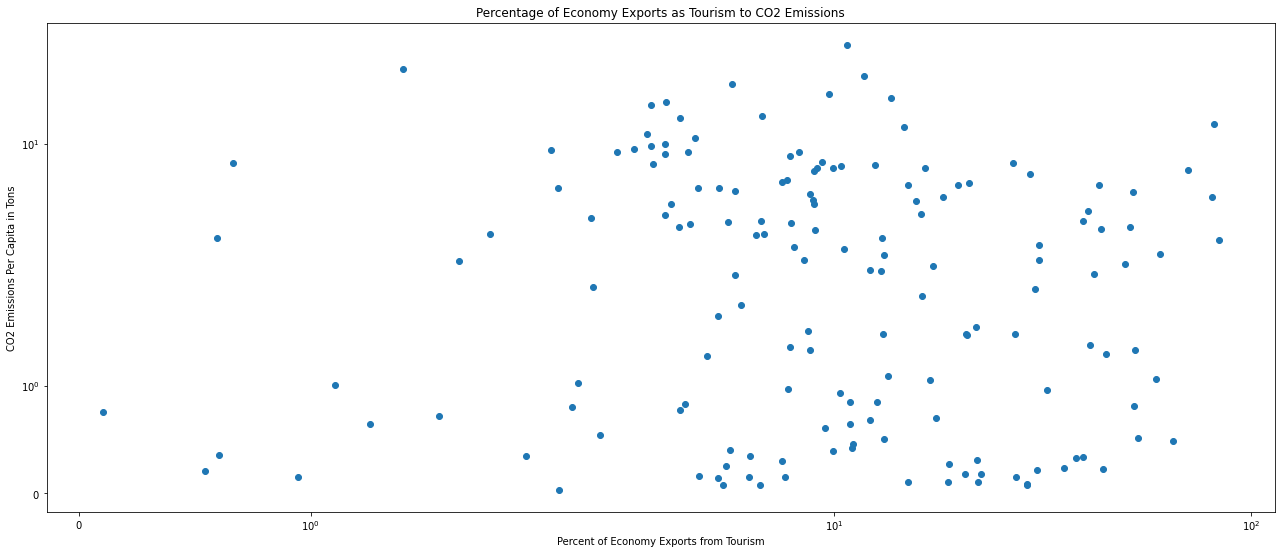

In [93]:
temp = tourism_to_pollution.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Percentage of Economy Exports as Tourism to CO2 Emissions")
plt.xlabel("Percent of Economy Exports from Tourism")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.xscale("symlog")
plt.yscale("symlog")

We expected to see countries with more stake in tourism having lower emissions, but we observe in fact a slightly positive correlation. This could be explained by the nations that are more highly targeted for tourism having other factors that cancel out the positive impact a stake in environment and tourist attractiveness. This may be because countries with more developed urban cities that contribute more heavily to emissions may attract tourists rather than just natural beauty. Also tourism to urban sites may result in more spending by the tourist as there are more commercial centers all around than in a more nature-oriented visit. This data is also impacted by the fact that larger, more developed countries may be the subject of more tourism as a ratio of exports, where the factors that contribute to increased emissions far outweighs the focus on tourism. Overall, the correlation is not exceedingly strong, so we look to other factors to build upon our model.

Next, we examine the relationship between the percent of exports made up for by fuel and emissions.

In [94]:
%%bigquery export_to_pollution --project $project_id
SELECT AVG(x.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y,
`bigquery-public-data.census_bureau_international.country_names_area` country
WHERE x.indicator_code = 'TX.VAL.FUEL.ZS.UN'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.country_name = country.country_name
AND x.country_code = y.country_code
GROUP BY x.country_name

Query is running:   0%|          |

Downloading:   0%|          |

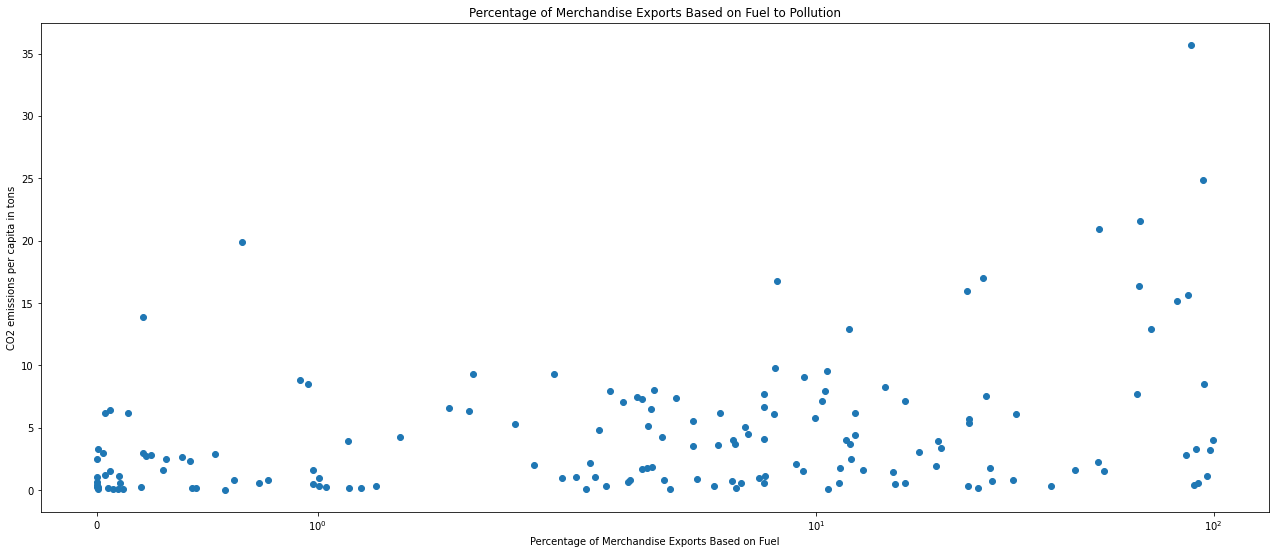

In [95]:
temp = export_to_pollution.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Percentage of Merchandise Exports Based on Fuel to Pollution")
plt.xlabel("Percentage of Merchandise Exports Based on Fuel")
plt.ylabel("CO2 emissions per capita in tons")
plt.xscale("symlog")

We observe a positive correlation between percent of merchandise exports based on fuel and emissions per capita. This is not entirely surprising as countries with more economic stake in fuel exports are more likely to undervalue environmental causes that would reduce demand for fuel. 

In [96]:
%%bigquery ODA_to_pollution --project $project_id
SELECT AVG(x.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y, `bigquery-public-data.census_bureau_international.country_names_area` country
WHERE x.indicator_code = 'DT.ODA.ODAT.PC.ZS'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.country_name = country.country_name
AND x.country_code = y.country_code
GROUP BY x.country_name

Query is running:   0%|          |

Downloading:   0%|          |

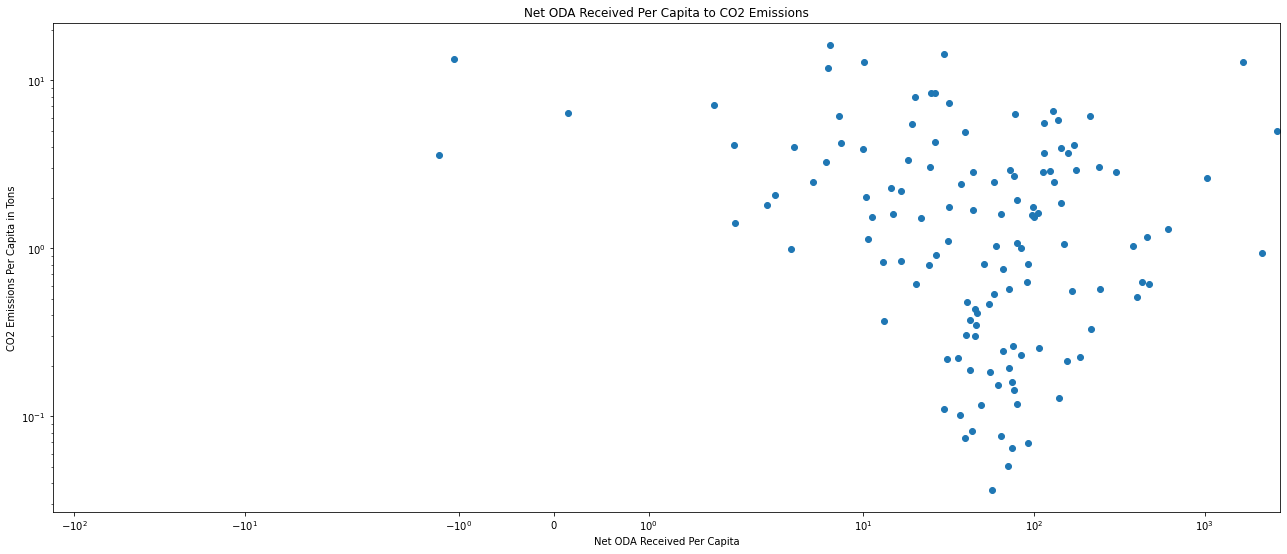

In [97]:
temp = ODA_to_pollution.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Net ODA Received Per Capita to CO2 Emissions")
plt.xlabel("Net ODA Received Per Capita")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.yscale("log")
plt.xscale("symlog")

Here we see the relationships between emissions and net official development assistance (ODA). ODA measures foreign aid and accounts for material resources given by the governments of richer countries to promote the economic development and citizen welfare of poorer countries. This measurement therefore will be higher for less wealthy and developed countries, so it makes sense that we would see a negative correlation, as more wealthy countries typically contribute to larger emissions.  

In [98]:
%%bigquery data4 --project $project_id
SELECT AVG(x.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y
WHERE x.indicator_code = 'SE.ENR.PRSC.FM.ZS'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.country_code = y.country_code
AND x.country_name IN(
  SELECT DISTINCT country.country_name
  FROM `bigquery-public-data.census_bureau_international.country_names_area` country
)
GROUP BY x.country_name

Query is running:   0%|          |

Downloading:   0%|          |

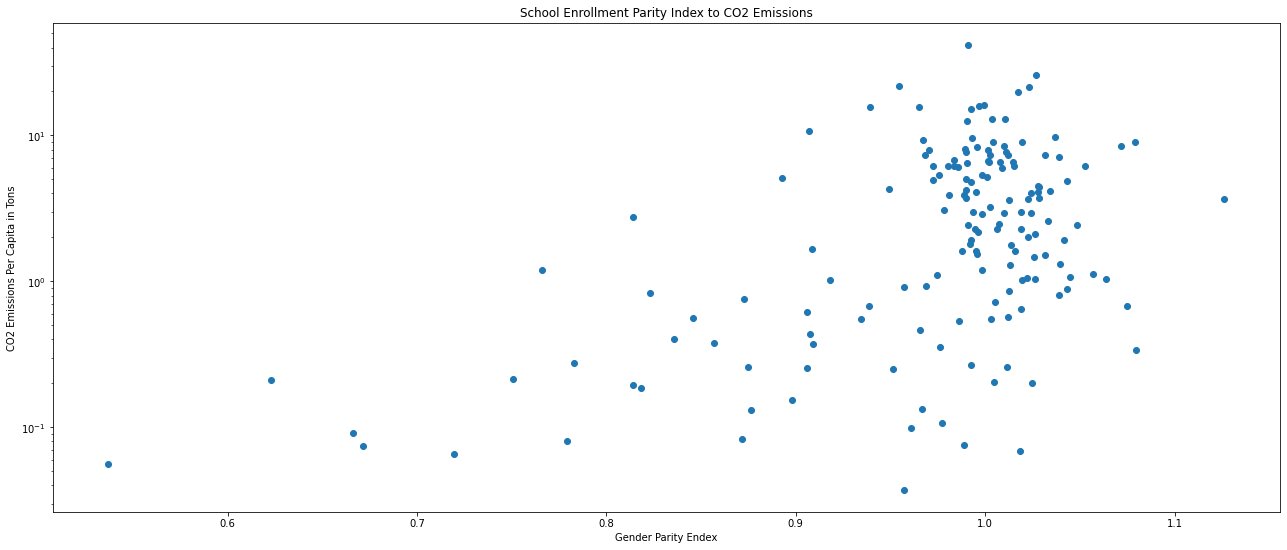

In [99]:
temp = data4.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("School Enrollment Parity Index to CO2 Emissions")
plt.xlabel("Gender Parity Endex")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.yscale("log")

Here we compare gender parity in primary school to CO2 emissions per capita. We theorize that this seeming correlation may be a result of school enrollment gender parity being a strong indicator of general quality of life. For instance a country that would give more equitable schooling would expect increased economic development, which in turn connects to larger resource consumption per capita. To test this theory, we will compare the rates of boys completing primary school with the gender parity of primary schools. We believe that a higher quality of education for even just boys in a country characterized by rates of graduation rates for boys will be positively correlated with a equal gender parity in primary school.

In [100]:
%%bigquery graudation_of_primary_to_parity --project $project_id
SELECT dep.graduation_value as independent, ind.parity_value as dependent
FROM (
  SELECT graduation.country_name as graduation_name, AVG(graduation.value) as graduation_value
  FROM `bigquery-public-data.world_bank_intl_education.international_education` graduation
  WHERE graduation.indicator_code = 'SE.PRM.CMPT.MA.ZS'
  AND graduation.year >= 2005
  AND graduation.year <= 2018
  AND graduation.country_name IN(
    SELECT country.country_name
    FROM `bigquery-public-data.census_bureau_international.country_names_area` country
  )
  GROUP BY graduation.country_name
) as dep
JOIN (
  SELECT parity.country_name as parity_name, AVG(parity.value) as parity_value
  FROM `bigquery-public-data.world_bank_wdi.indicators_data` parity
  WHERE parity.indicator_code = 'SE.ENR.PRSC.FM.ZS'
  AND parity.year >= 2005
  AND parity.year <= 2018
  AND parity.country_name IN(
    SELECT country.country_name
    FROM `bigquery-public-data.census_bureau_international.country_names_area` country
  )
  GROUP BY parity.country_name
) as ind
ON dep.graduation_name = ind.parity_name

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Gender Parity')

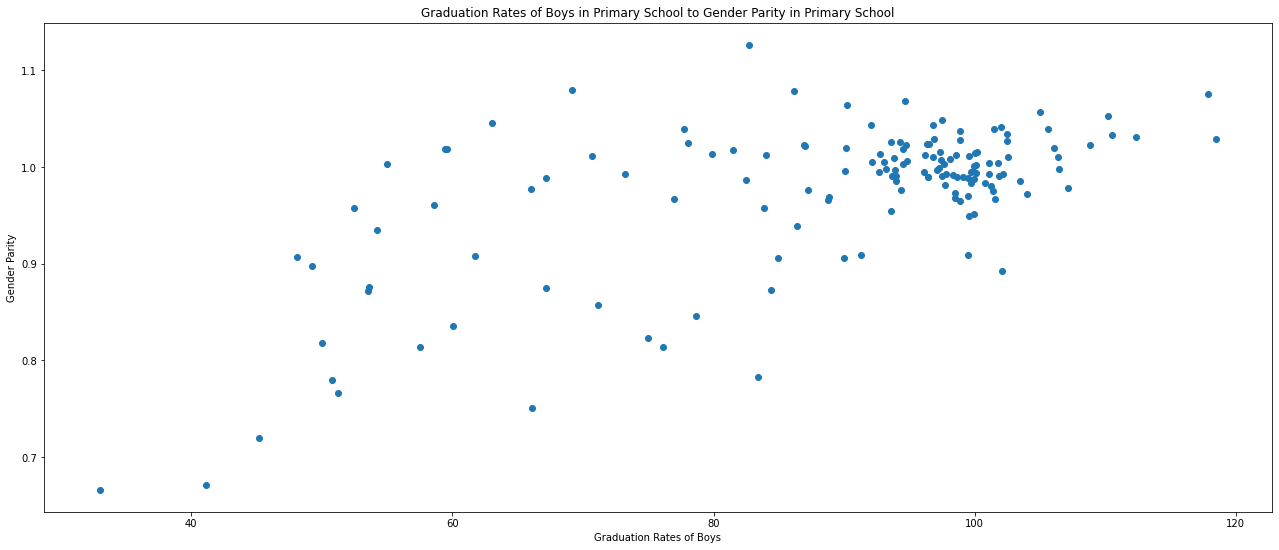

In [101]:
temp = graudation_of_primary_to_parity.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Graduation Rates of Boys in Primary School to Gender Parity in Primary School")
plt.xlabel("Graduation Rates of Boys")
plt.ylabel("Gender Parity")

quick note: We observe that ratios can be over 100 percent in countries with high rates of completion as the World Bank collects this metric by comparing admission numbers between years.

https://databank.worldbank.org/metadataglossary/gender-statistics/series/SE.PRM.CMPT.FE.ZS

This data helps confirm our intuition that a higher quality education is heavily correlated with equal representation of genders. Seeing this result we propose engineering a feature that finds a ratio between gender parity in primary school and male primary completion rates to represent a countries relative interest in providing high quality education equally.

In [66]:
%%bigquery education_equality_ratio --project $project_id
SELECT ratio_data.dependent, carbon_data.carbon_value as independent
FROM (SELECT dep.graduation_value / ind.parity_value as dependent, dep.graduation_name as ratio_name
  FROM (
    SELECT graduation.country_name as graduation_name, AVG(graduation.value) as graduation_value
    FROM `bigquery-public-data.world_bank_intl_education.international_education` graduation
    WHERE graduation.indicator_code = 'SE.PRM.CMPT.MA.ZS'
    AND graduation.year >= 2005
    AND graduation.year <= 2018
    AND graduation.country_name IN(
      SELECT country.country_name
      FROM `bigquery-public-data.census_bureau_international.country_names_area` country
    )
    GROUP BY graduation.country_name
  ) as dep
  JOIN (
    SELECT parity.country_name as parity_name, AVG(parity.value) as parity_value
    FROM `bigquery-public-data.world_bank_wdi.indicators_data` parity
    WHERE parity.indicator_code = 'SE.ENR.PRSC.FM.ZS'
    AND parity.year >= 2005
    AND parity.year <= 2018
    AND parity.country_name IN(
      SELECT country.country_name
      FROM `bigquery-public-data.census_bureau_international.country_names_area` country
    )
    GROUP BY parity.country_name
  ) as ind
  ON dep.graduation_name = ind.parity_name
  ) as ratio_data
JOIN (
  SELECT y.country_name as carbon_name, AVG(y.value) as carbon_value
  FROM `bigquery-public-data.world_bank_wdi.indicators_data` y
  WHERE y.indicator_code = 'EN.ATM.CO2E.PC'
  AND y.year >= 2005
  AND y.year <= 2018
  GROUP BY y.country_name
) as carbon_data
ON ratio_data.ratio_name = carbon_data.carbon_name


Query is running:   0%|          |

Downloading:   0%|          |

144


Text(0, 0.5, 'Pollution')

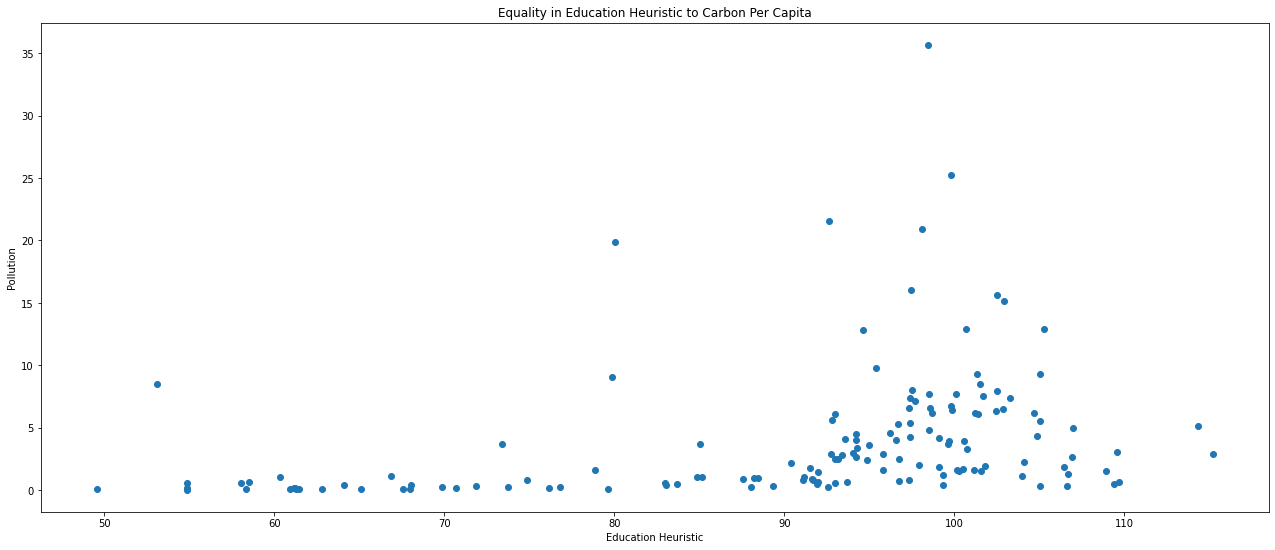

In [67]:
temp = education_equality_ratio.copy()
print(len(temp["dependent"]))
plt.figure(figsize=(22,9))
plt.scatter(temp["dependent"], temp["independent"])
plt.title("Equality in Education Heuristic to Carbon Per Capita")
plt.xlabel("Education Heuristic")
plt.ylabel("Pollution")

This initially seems to suggest that there is a slight correlation between gender inequality in schooling normalized for quality and CO2 emissions per capita, but with the amount of factors playing into this engineered feature, it is hard to directly prove a correlation. For instance the value seems to spike at 100 which would reasonable weigh around boys achieving near 100 percent primary school completion rates and parity approaching 1 as a school system develops. We are lead to believe this suggests a very strong correlation between a country's school system reaching a stance of maturity of completion and gender parity, which allows a country to develop.

Since our data seems to suggest wealth as a primary source of CO2 emissions, we also wish to investigate investment in R&D as a heuristic for a scientifically advanced country.

In [102]:
%%bigquery data11 --project $project_id
SELECT AVG(x.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y,`bigquery-public-data.world_bank_wdi.indicators_data` country
WHERE x.indicator_code = 'SP.POP.SCIE.RD.P6'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.country_name = country.country_name
AND x.country_code = y.country_code
GROUP BY x.country_name

Query is running:   0%|          |

Downloading:   0%|          |

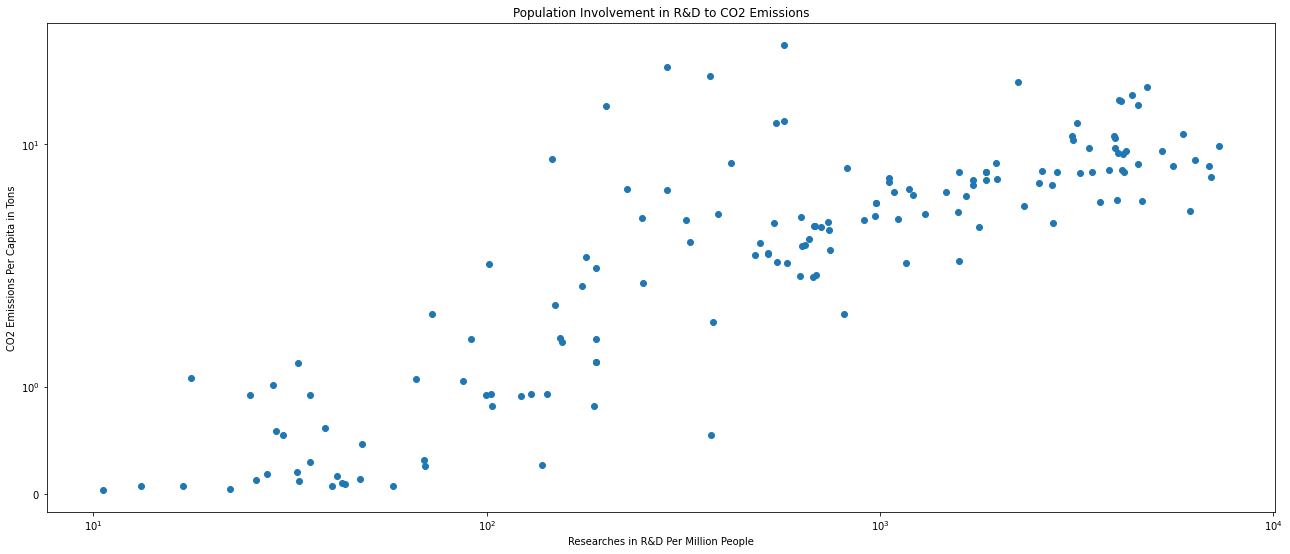

In [103]:
temp = data11.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Population Involvement in R&D to CO2 Emissions")
plt.xlabel("Researches in R&D Per Million People")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.yscale("symlog")
plt.xscale("symlog")

Here, we see a positive correlation between number of researchers involved in R&D and emissions. Though R&D is very broad, we hypothesized that countries with higher numbers of people working in research would positively correlate with numbers of researchers in environmental research or research that would reduce emissions or at least have that as a goal. We might have hoped to see that countries with more people in research would start to show reduced emissions. However, we see the opposite, though this is also probably related to countries with more research being wealthier and more developed. Though these countries now have higher emissions, perhaps they will be some of the first to see a reduction further on. 

In [104]:
%%bigquery data12 --project $project_id
SELECT AVG(x.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y,`bigquery-public-data.census_bureau_international.midyear_population` country
WHERE x.indicator_code = 'GB.XPD.RSDV.GD.ZS'
AND y.indicator_code = 'EN.ATM.CO2E.PC'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.country_name = country.country_name
AND x.country_code = y.country_code
AND x.year = country.year
GROUP BY x.country_name

Query is running:   0%|          |

Downloading:   0%|          |

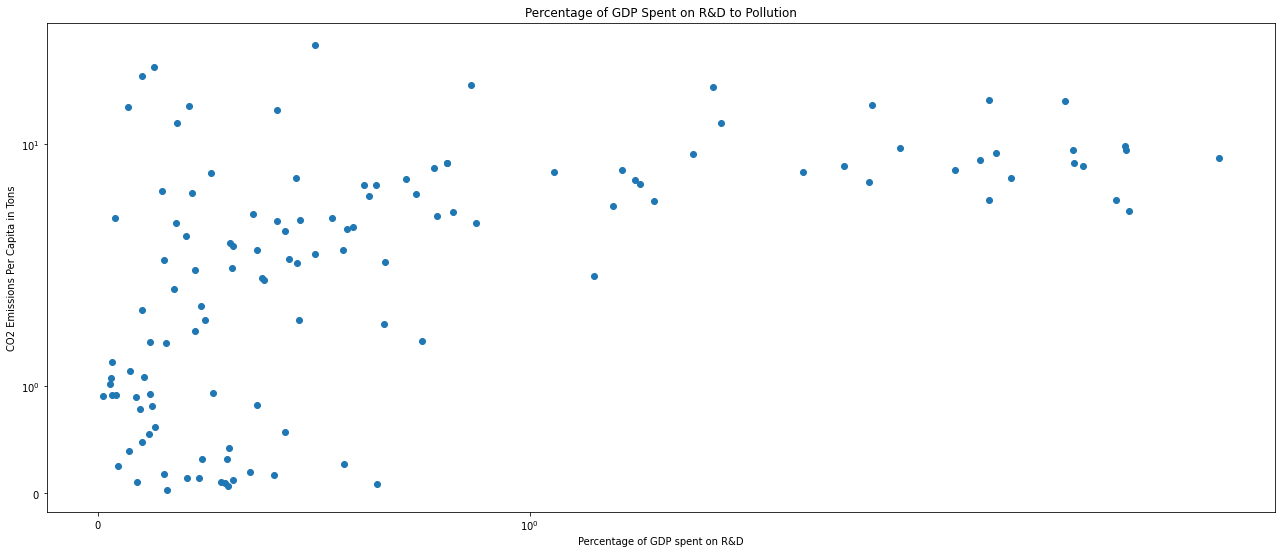

In [105]:
temp = data12.copy()
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Percentage of GDP Spent on R&D to Pollution")
plt.xlabel("Percentage of GDP spent on R&D")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.yscale("symlog")
plt.xscale("symlog")

We see a positive correlation between a country's expenditure into R&D. We believe this is because a more developed economy will likely be produce a large amount of pollution while also having more excess funding to spend on funding research. Interestingly though, we do seem to see that as R&D funding increases, the amount of carbon pollution does seem to level off. Though we do not see corrections to high CO2 emissions per capita, this may suggest increase scientific development makes curbing of continued emissions a stronger objective. To further explore this we are curious to see if this is a result of active development versus existence in a state of being developed.

In [106]:
%%bigquery researcher_change --project $project_id
SELECT AVG(x.value - previous.value) as independent, AVG(y.value) as dependent 
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.world_bank_wdi.indicators_data` y,`bigquery-public-data.world_bank_wdi.indicators_data` country, `bigquery-public-data.world_bank_wdi.indicators_data` previous
WHERE x.indicator_code = 'GB.XPD.RSDV.GD.ZS'
AND previous.indicator_code = x.indicator_code
AND y.indicator_code = 'EN.ATM.GHGT.KT.CE'
AND x.year >= 2005
AND x.year <= 2018
AND x.year = y.year
AND x.year = previous.year + 5
AND x.country_name = country.country_name
AND x.country_code = y.country_code
AND x.country_code = previous.country_code
GROUP BY x.country_name

Query is running:   0%|          |

Downloading:   0%|          |

129


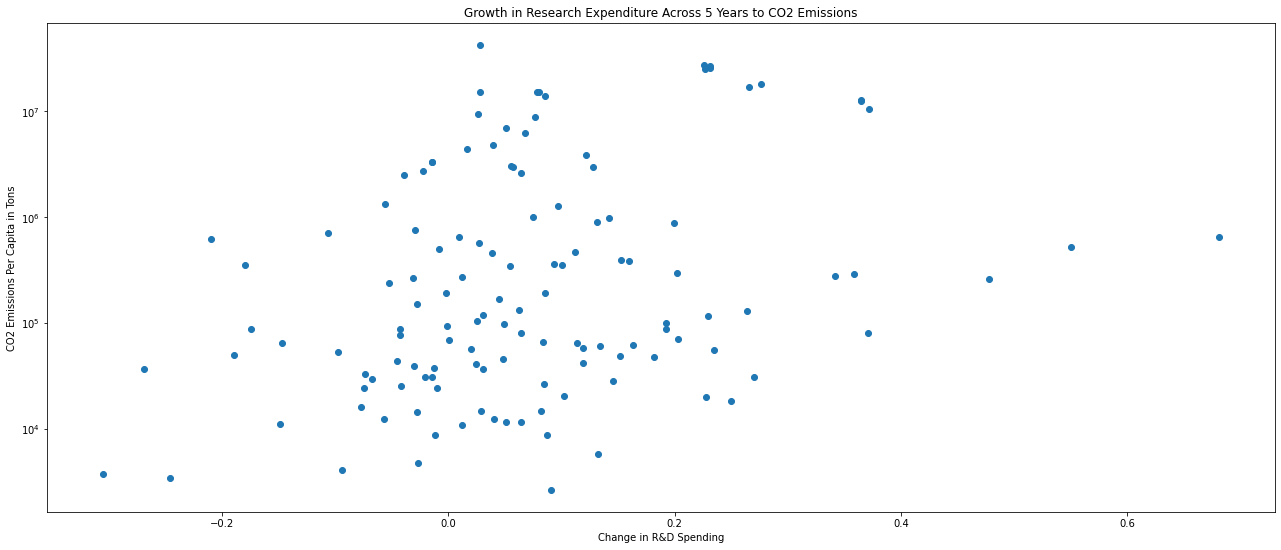

In [107]:
temp = researcher_change.copy()
print(len(temp["dependent"]))
plt.figure(figsize=(22,9))
plt.scatter(temp["independent"], temp["dependent"])
plt.title("Growth in Research Expenditure Across 5 Years to CO2 Emissions")
plt.xlabel("Change in R&D Spending")
plt.ylabel("CO2 Emissions Per Capita in Tons")
plt.yscale("symlog")

Though we not see a particularly strong correlation, we do see that countries with an abnormally large amount of researchers do generally go above the median amount of greenhouse gas emissions. Ultimately we are unable to find a strong connection between rates of growth and instead see that emissions are largely dependent on a country's present relation to R&D and not how this relationship changes.

## Data Prediction

In order to run our tests we will divide up our countries into a training, validation, and testing set in a 70-10-20 ratio.

At a TA's advice we split up countries by sorting them by volumes of CO2 and and taking every fifth country for testing and every tenth for validation with an offset. Leftover countries are left for training:

In [ ]:
%%bigquery --project $project_id
insert into `basicproject-364421.countries_for_testing.testing_countries` (
  select country_name from (SELECT *, row_number() over() as country_rows
FROM(SELECT AVG(x.value / country.midyear_population) as emissions, x.country_name
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.census_bureau_international.midyear_population` country
WHERE x.indicator_code = 'EN.ATM.GHGT.KT.CE'
AND x.year = 2015
AND country.year = x.year
AND x.country_name = country.country_name
GROUP BY x.country_name
ORDER BY emissions DESC))
WHERE MOD(country_rows,5)=0
)

In [ ]:
%%bigquery --project $project_id
insert into `basicproject-364421.countries_for_testing.validating_countries` (
  select country_name from (SELECT *, row_number() over() as country_rows
FROM(SELECT AVG(x.value / country.midyear_population) as emissions, x.country_name
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.census_bureau_international.midyear_population` country
WHERE x.indicator_code = 'EN.ATM.GHGT.KT.CE'
AND x.year = 2015
AND country.year = x.year
AND x.country_name = country.country_name
GROUP BY x.country_name
ORDER BY emissions DESC))
WHERE MOD(country_rows+1,10)=0
)

In [ ]:
%%bigquery --project $project_id
insert into `basicproject-364421.countries_for_testing.training_countries` (
SELECT x.country_name
FROM `bigquery-public-data.world_bank_wdi.indicators_data` x, `bigquery-public-data.census_bureau_international.midyear_population` country
WHERE x.indicator_code = 'EN.ATM.GHGT.KT.CE'
AND x.year = 2015
AND country.year = x.year
AND x.country_name = country.country_name
AND x.country_name NOT IN (
  SELECT DISTINCT lower_order.country_name
  FROM `basicproject-364421.countries_for_testing.validating_countries` lower_order
)
AND x.country_name NOT IN (
  SELECT DISTINCT lower_order.country_name
  FROM `basicproject-364421.countries_for_testing.testing_countries` lower_order
)
GROUP BY x.country_name
)

Next we need to find the median of the data.

In [ ]:
%%bigquery --project $project_id
SELECT AVG(a.value) as CO2PerCapita, a.country_name
FROM `bigquery-public-data.world_bank_wdi.indicators_data` a,
`bigquery-public-data.census_bureau_international.country_names_area` b
WHERE a.indicator_code = 'EN.ATM.CO2E.PC'
AND a.year >= 2005
AND a.year <= 2018
AND a.country_name = b.country_name
GROUP BY a.country_name
ORDER BY CO2PerCapita DESC
LIMIT 2
OFFSET 84

Query is running:   0%|          |

Downloading:   0%|          |

,CO2PerCapita,country_name
0,2.638564,Marshall Islands
1,2.496883,Panama


Yielding a median of 2.5677

Now that we have divided our countries into training, validation, and testing, we can as per TA instruction, preprocess the data such that it is easier to world directly with our features in the ML step.

The label is if the country of 2005-2018 had an average CO2 emission rate above or below the median.

For some of our features, we run a pseudo symlog transformation on the data where if the value is less than .5, we set the value constant at log(.5)=-.3. For greater values we log the value. This is because in our tables we see that due to the disproportianate size of countries, the data distributions at times appear to more heavily follow an exponential pattern. We found in the data exploration section that by running the symlog operation, the distribution across different values across some indicators became far more uniform. At the very least, in the case of significant outliers, they would be smoothed out without being erased. This would help train the model which by default takes in the features linearly without the use of a feature extractor. We specify features with these transformations by *

Feature1*: The percentage of the population living in cities with a population of over 1 million people.

Feature2: Our engineered feature of the ratio of wealth held by the top ten percent of the population over the reation held by the bottom ten percent.

Feature3: Our engineered discreticized feature over whether or not 95 percent of the population has access to electricity.

Feature4*: The percent of the country's merchandise exports as fuel.

Feature5: The gender parity of primary schools.

Feature6: The square of the gender parity of primary schools to best fit around the observed polynomial increase.

Feature7*: The percent of an economy's exports as receiving tourism.

Feature8*: The percent of an economy's GDP being spent on research and development.

In [ ]:
insert into `basicproject-364421.countries_for_testing.it2ML`
SELECT layer7.country_name as country_name, layer7.carbon_value as carbon_value, layer7.density_value as density_value, layer7.inequality_ratio as inequality_ratio,
layer7.electricity as electricity, layer7.export_val as export_val, layer7.education_vals as education_vals, layer7.education_vals2 as education_vals2,
layer7.tourism_export_val as tourism_export_val, new7.rdspending as rdspending
FROM (SELECT layer6.country_name as country_name, layer6.carbon_value as carbon_value, layer6.density_value as density_value, layer6.inequality_ratio as inequality_ratio,
      layer6.electricity as electricity, layer6.export_val as export_val, layer6.education_vals as education_vals, layer6.education_vals2 as education_vals2,
      new6.tourism_export as tourism_export_val
FROM (SELECT layer5.country_name as country_name, layer5.carbon_value as carbon_value, layer5.density_value as density_value, layer5.inequality_ratio as inequality_ratio,
      layer5.electricity as electricity, layer5.export_val as export_val, new5.education_vals as education_vals, new5.education_vals2 as education_vals2
FROM (SELECT layer4.country_name as country_name, layer4.carbon_value as carbon_value, layer4.density_value as density_value, layer4.inequality_ratio as inequality_ratio,
      layer4.electricity as electricity, new4.export_val as export_val
FROM (
  SELECT layer3.country_name as country_name, layer3.carbon_value as carbon_value, layer3.density_value as density_value, layer3.inequality_ratio as inequality_ratio,
  new3.electricity as electricity
  FROM (
    SELECT layer2.country_name as country_name, layer2.carbon_value as carbon_value, layer2.density_value as density_value, new2.inequality_ratio as inequality_ratio
    FROM (
      SELECT layer1.country_name as country_name, layer1.carbon_value as carbon_value, new1.density_value as density_value
      FROM (
        SELECT carbon.country_name as country_name, avg(carbon.value) as carbon_value
        FROM `bigquery-public-data.world_bank_wdi.indicators_data` carbon
        WHERE carbon.indicator_code = 'EN.ATM.CO2E.PC'
        AND carbon.year >= 2005
        AND carbon.year <= 2018
        AND carbon.country_name IN (
          SELECT x.country_name
          FROM `bigquery-public-data.census_bureau_international.country_names_area` x
      )
      GROUP BY carbon.country_name) AS layer1
      LEFT JOIN (
        SELECT density.country_name as country_name, avg(density.value) as density_value
        FROM `bigquery-public-data.world_bank_wdi.indicators_data` density
        WHERE density.indicator_code = 'EN.URB.MCTY.TL.ZS'
        AND density.year >= 2005
        AND density.year <= 2018
        GROUP BY density.country_name
      ) AS new1
      ON layer1.country_name = new1.country_name
    ) AS layer2
    LEFT JOIN (
      SELECT lower_wealth.country_name as country_name, avg(lower_wealth.value / upper_wealth.value) as inequality_ratio
      FROM `bigquery-public-data.world_bank_wdi.indicators_data` lower_wealth, `bigquery-public-data.world_bank_wdi.indicators_data` upper_wealth
      WHERE lower_wealth.indicator_code = 'SI.DST.FRST.10'
      AND upper_wealth.indicator_code = 'SI.DST.10TH.10'
      AND lower_wealth.year >= 2005
      AND lower_wealth.year <= 2018
      AND lower_wealth.year = upper_wealth.year
      AND lower_wealth.country_name = upper_wealth.country_name
      GROUP BY lower_wealth.country_name
    ) as new2
    ON layer2.country_name = new2.country_name
  ) as layer3
  LEFT JOIN (
    SELECT electricity_access.country_name as country_name, IF(AVG(electricity_access.value) > 95, 1, 0) as electricity
    FROM `bigquery-public-data.world_bank_wdi.indicators_data` electricity_access
    WHERE electricity_access.indicator_code = 'EG.ELC.ACCS.ZS'
    AND electricity_access.year >= 2005
    AND electricity_access.year <= 2018
    GROUP BY electricity_access.country_name
  ) as new3
  ON layer3.country_name = new3.country_name
) as layer4
LEFT JOIN (
  SELECT export_value.country_name as country_name, AVG(export_value.value) as export_val
  FROM `bigquery-public-data.world_bank_wdi.indicators_data` export_value
  WHERE export_value.indicator_code = 'TX.VAL.FUEL.ZS.UN'
  AND export_value.year >= 2005
  AND export_value.year <= 2018
  GROUP BY export_value.country_name
) as new4
ON layer4.country_name = new4.country_name
) as layer5
LEFT JOIN (
  SELECT education_val.country_name as country_name, AVG(education_val.value) as education_vals, (AVG(education_val.value) * AVG(education_val.value)) as education_vals2 
  FROM `bigquery-public-data.world_bank_wdi.indicators_data` education_val
  WHERE education_val.indicator_code = 'SE.ENR.PRSC.FM.ZS'
  AND education_val.year >= 2005
  AND education_val.year <= 2018
  GROUP BY education_val.country_name
) as new5
ON layer5.country_name = new5.country_name
) as layer6
LEFT JOIN (
  SELECT tourism.country_name as country_name, AVG(tourism.value) as tourism_export 
  FROM `bigquery-public-data.world_bank_wdi.indicators_data` tourism
  WHERE tourism.indicator_code = 'ST.INT.RCPT.XP.ZS'
  AND tourism.year >= 2005
  AND tourism.year <= 2018
  GROUP BY tourism.country_name) as new6
ON layer6.country_name = new6.country_name) as layer7
LEFT JOIN (
  SELECT rdspendt.country_name as country_name, AVG(rdspendt.value) as rdspending 
  FROM `bigquery-public-data.world_bank_wdi.indicators_data` rdspendt
  WHERE rdspendt.indicator_code = 'GB.XPD.RSDV.GD.ZS'
  AND rdspendt.year >= 2005
  AND rdspendt.year <= 2018
  GROUP BY rdspendt.country_name
) as new7
ON layer7.country_name = new7.country_name


In [ ]:
model_dataset_name = 'emissions_predictor_final_model'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('basicproject-364421', 'emissions_predictor_final_model'))

In [ ]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `emissions_predictor_final_model.emissions_model`
OPTIONS(model_type='logistic_reg') AS
SELECT IF(carbon_value > 2.5677, 1, 0) as label, IF(density_value < .5, -.3, LOG(density_value)) as feature1,
inequality_ratio as feature2, electricity as feature3,
IF(export_val < .5, -.3, LOG(export_val)) as feature4, education_vals as feature5, education_vals2 as feature6,
IF(tourism_export < .5, -.3, LOG(tourism_export)) as feature7,
IF(rdspending < .5, -.3, LOG(rdspending)) as feature8
FROM `basicproject-364421.countries_for_testing.it2ML`
WHERE country_name IN (
  SELECT country_name
  FROM `basicproject-364421.countries_for_testing.training_countries`
)

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `emissions_predictor_final_model.emissions_model`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.388296,NaN,12.8,2459
1,0,5,0.389581,NaN,6.4,2454
2,0,4,0.397802,NaN,3.2,2171
3,0,3,0.428223,NaN,1.6,2409
4,0,2,0.491056,NaN,0.8,2510
5,0,1,0.572758,NaN,0.4,2517
6,0,0,0.644703,NaN,0.2,2149


In [ ]:
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.EVALUATE(MODEL `emissions_predictor_final_model.emissions_model`, (
  SELECT IF(carbon_value > 2.5677, 1, 0) as label, IF(density_value < .5, -.3, LOG(density_value)) as feature1,
  inequality_ratio as feature2, electricity as feature3,
  IF(export_val < .5, -.3, LOG(export_val)) as feature4, education_vals as feature5, education_vals2 as feature6,
  IF(tourism_export < .5, -.3, LOG(tourism_export)) as feature7,
  IF(rdspending < .5, -.3, LOG(rdspending)) as feature8
  FROM `basicproject-364421.countries_for_testing.it2ML`
  WHERE country_name IN (
    SELECT country_name
    FROM `basicproject-364421.countries_for_testing.training_countries`
  )
  )) 

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.83871,0.866667,0.848739,0.852459,0.388296,0.897012


In [ ]:
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.EVALUATE(MODEL `emissions_predictor_final_model.emissions_model`, (
  SELECT IF(carbon_value > 2.5677, 1, 0) as label, IF(density_value < .5, -.3, LOG(density_value)) as feature1,
  inequality_ratio as feature2, electricity as feature3,
  IF(export_val < .5, -.3, LOG(export_val)) as feature4, education_vals as feature5, education_vals2 as feature6,
  IF(tourism_export < .5, -.3, LOG(tourism_export)) as feature7,
  IF(rdspending < .5, -.3, LOG(rdspending)) as feature8
  FROM `basicproject-364421.countries_for_testing.it2ML`
  WHERE country_name IN (
    SELECT country_name
    FROM `basicproject-364421.countries_for_testing.validating_countries`
  )
  )) 

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.857143,0.857143,0.882353,0.857143,0.299541,0.958143


In [ ]:
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.EVALUATE(MODEL `emissions_predictor_final_model.emissions_model`, (
  SELECT IF(carbon_value > 2.5677, 1, 0) as label, IF(density_value < .5, -.3, LOG(density_value)) as feature1,
  inequality_ratio as feature2, electricity as feature3,
  IF(export_val < .5, -.3, LOG(export_val)) as feature4, education_vals as feature5, education_vals2 as feature6,
  IF(tourism_export < .5, -.3, LOG(tourism_export)) as feature7,
  IF(rdspending < .5, -.3, LOG(rdspending)) as feature8
  FROM `basicproject-364421.countries_for_testing.it2ML`
  WHERE country_name IN (
    SELECT country_name
    FROM `basicproject-364421.countries_for_testing.testing_countries`
  )
  )) 

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.809524,0.944444,0.852941,0.871795,0.36666,0.914059


We see a relatively strong model for prediction. We believe that the model is able to reliably predict in training and generalize well to the testing data because as per our previous observations while exploring the data, we have found that indicators that would reasonable correlate with economic development and wealth correlate with a high per capita emission rate of CO2. As such we believe the model is able to use this underlying correlation in a lot of its predictions. As we have seen in our exploration of the data, though there are often correlations, the data itself seems to be noisy with large variations across specific countries. We believe that there are still some relationships between various indicators that go beyond general wealth, but since they would involve relating to each other, this analysis would be necessarily high dimensional and difficult to recognize with pure visualization. For example, perhaps there is a niche of small countries with a lot of tourism due to their natural beauty that might invest a lot in researching sustainability to protecting their environment and have low emissions as a result. This would represent a difficult to identify correlation. We believe the model is able to pick on some of these relationships to achieve a 85 percent accuracy in testing.
We primarily look at raw accuracy as our of metric of succes. This is because we are predicting around the median, so the data is necessarily balanced and the model cannot get away with only guessing one side. Recall is also important as we don't want to miss out on identifying a country that is causing harm through emissions, but isn't detected. As such we see a high recall as a positive result. We see that precision and recall are also very close in all three evaluation metrics suggesting a generally reliable model that doesn't excessively make either false postives or false negatives in one direction. 

## Conclusion

---

Our ultimate finding is that the development of a country is generally in line with the World Bank and other institutions and inversely correlated with success in protecting the environment. We consider this conclusion to be fairly intuitive as it is plainly observed that wealthy countries like the United States of America have high per capita emissions. We have analyzed correlations between a variety of factors. One thing we observe is that our hypotheses seem to generally relate to how developed and wealth a country is. In general signs of economic development like research and education seem to be the primary predictors for CO2 emissions. However we realize that the issue of sustainable development is much larger than can be easily expressed by a one size fits all dataset. Despite this, we were generally surprised at how some factors like tourism seemed to have such little relation to emissions. There are many political factors correlating to pollution that can exacerbate this issue. An example being how in America taking action around greenhouse gas pollution can be seen as a partisan issue. What we personally observe from this dataset, however, is an interesting and provocative finding as this suggests that countries are unlikely to take proactive measurements against climate change through just education and research on their own. We use these findings to help justify the importance and implementation of international treaties like the Paris Agreement to help solve the issue at an internation level. We believe that with more hardline policies, countries would find environmenal preservation within their benefit to maintain development.




---